In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline
from astropy.io import fits
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Import ground truth convergence validation map

In [3]:
convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')

Import results on the validation map

In [4]:
root = '/linkhome/rech/genpuc01/utb76xl/jl/scripts/results/validation/annealed_hmc/seeds/samples_hmc_'
sample = fits.getdata(root+'1.fits')
sample = np.concatenate([sample, fits.getdata(root+'2.fits')], axis=0).reshape(-1,360,360)
sample = np.concatenate([sample, fits.getdata(root+'3.fits')], axis=0).reshape(-1,360,360)
for i in range(4, 51):
    s = fits.getdata(root+str(i)+'.fits')
    sample = np.concatenate([sample, s], axis=0)

root = '/linkhome/rech/genpuc01/utb76xl/jl/scripts/results/validation/annealed_hmc/seeds/samples_denoised_'
denoised = fits.getdata(root+'1.fits')
denoised = np.concatenate([denoised, fits.getdata(root+'2.fits')], axis=0).reshape(-1,360,360)
denoised = np.concatenate([denoised, fits.getdata(root+'3.fits')], axis=0).reshape(-1,360,360)
for i in range(4, 51):
    s = fits.getdata(root+str(i)+'.fits')
    denoised = np.concatenate([denoised, s], axis=0)
        
print(sample.shape)
print(denoised.shape)

(500, 360, 360)
(500, 360, 360)


Import results on the COSMOS field

In [5]:
#root = '/linkhome/rech/genpuc01/utb76xl/jl/scripts/results/cosmos/annealed_hmc/seeds/samples_hmc_'
root = '/linkhome/rech/genpuc01/utb76xl/jl/scripts/results/cosmos/annealed_hmc/seeds/samples_denoised_'
cosmos = fits.getdata(root+'1.fits')
cosmos = np.concatenate([cosmos, fits.getdata(root+'2.fits')], axis=0).reshape(-1,360,360)
cosmos = np.concatenate([cosmos, fits.getdata(root+'3.fits')], axis=0).reshape(-1,360,360)
for i in range(4, 51):
    if (i<11 or i>20):
        s = fits.getdata(root+str(i)+'.fits')
        cosmos = np.concatenate([cosmos, s], axis=0)
cosmos.shape

(400, 360, 360)

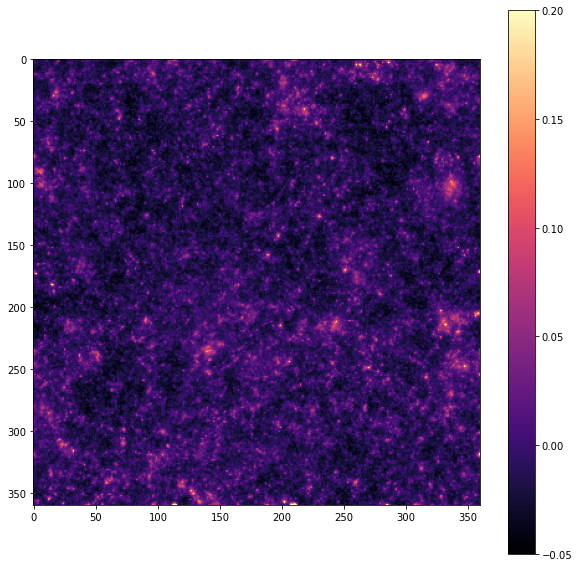

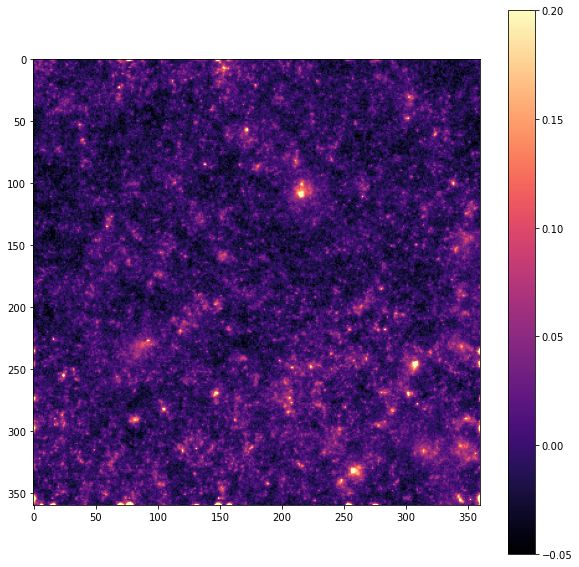

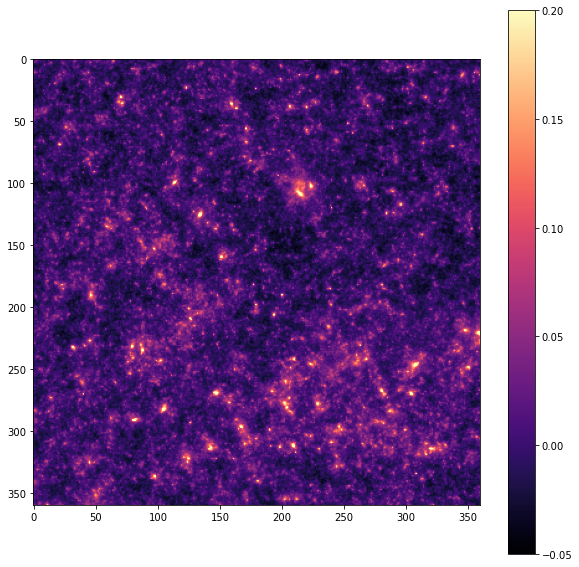

In [6]:
figure(figsize=(10,10))
imshow(cosmos[1,...], cmap='magma', vmin=-0.05, vmax=0.2)
colorbar()

figure(figsize=(10,10))
imshow(sample[0,...], cmap='magma', vmin=-0.05, vmax=0.2)
colorbar()

figure(figsize=(10,10))
imshow(convergence, cmap='magma', vmin=-0.05, vmax=0.2)
colorbar()

(100, 50000.0)

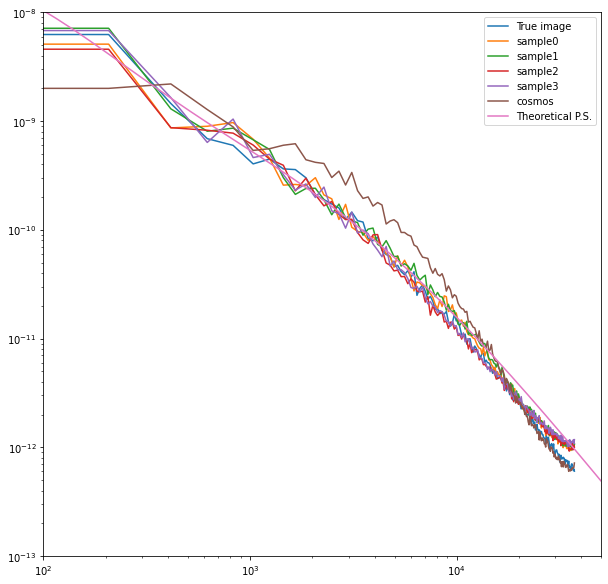

In [7]:
from jax_lensing.spectral import measure_power_spectrum
resolution = 0.29
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

figure(figsize=(10,10))

l_true, C_true = measure_power_spectrum(convergence, pixel_size)
loglog(l_true, C_true , label='True image')

l_f, C_f = measure_power_spectrum(sample[0,...], pixel_size)
loglog(l_f, C_f,label='sample0')
l_f, C_f = measure_power_spectrum(sample[1,...], pixel_size)
loglog(l_f, C_f,label='sample1')
l_f, C_f = measure_power_spectrum(sample[2,...], pixel_size)
loglog(l_f, C_f,label='sample2')
l_f, C_f = measure_power_spectrum(sample[3,...], pixel_size)
loglog(l_f, C_f,label='sample3')

l_f, C_f = measure_power_spectrum(cosmos[0,...], pixel_size)
loglog(l_f, C_f,label='cosmos')

gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = np.load(gaussian_path).astype('float32')
loglog(ps_data_th[0,:], ps_data_th[1,:], label='Theoretical P.S.')

legend()
ylim(1.e-13,1e-8)
xlim(100,5e4)

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# These show the borders of the cosmos field
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

from lenspack.geometry.projections import gnom
def get_extend_radec(res, width):
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

In [9]:
samples = sample
samples.shape

(500, 360, 360)

## Point estimate

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/tensorflow-gpu-2.5.0/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


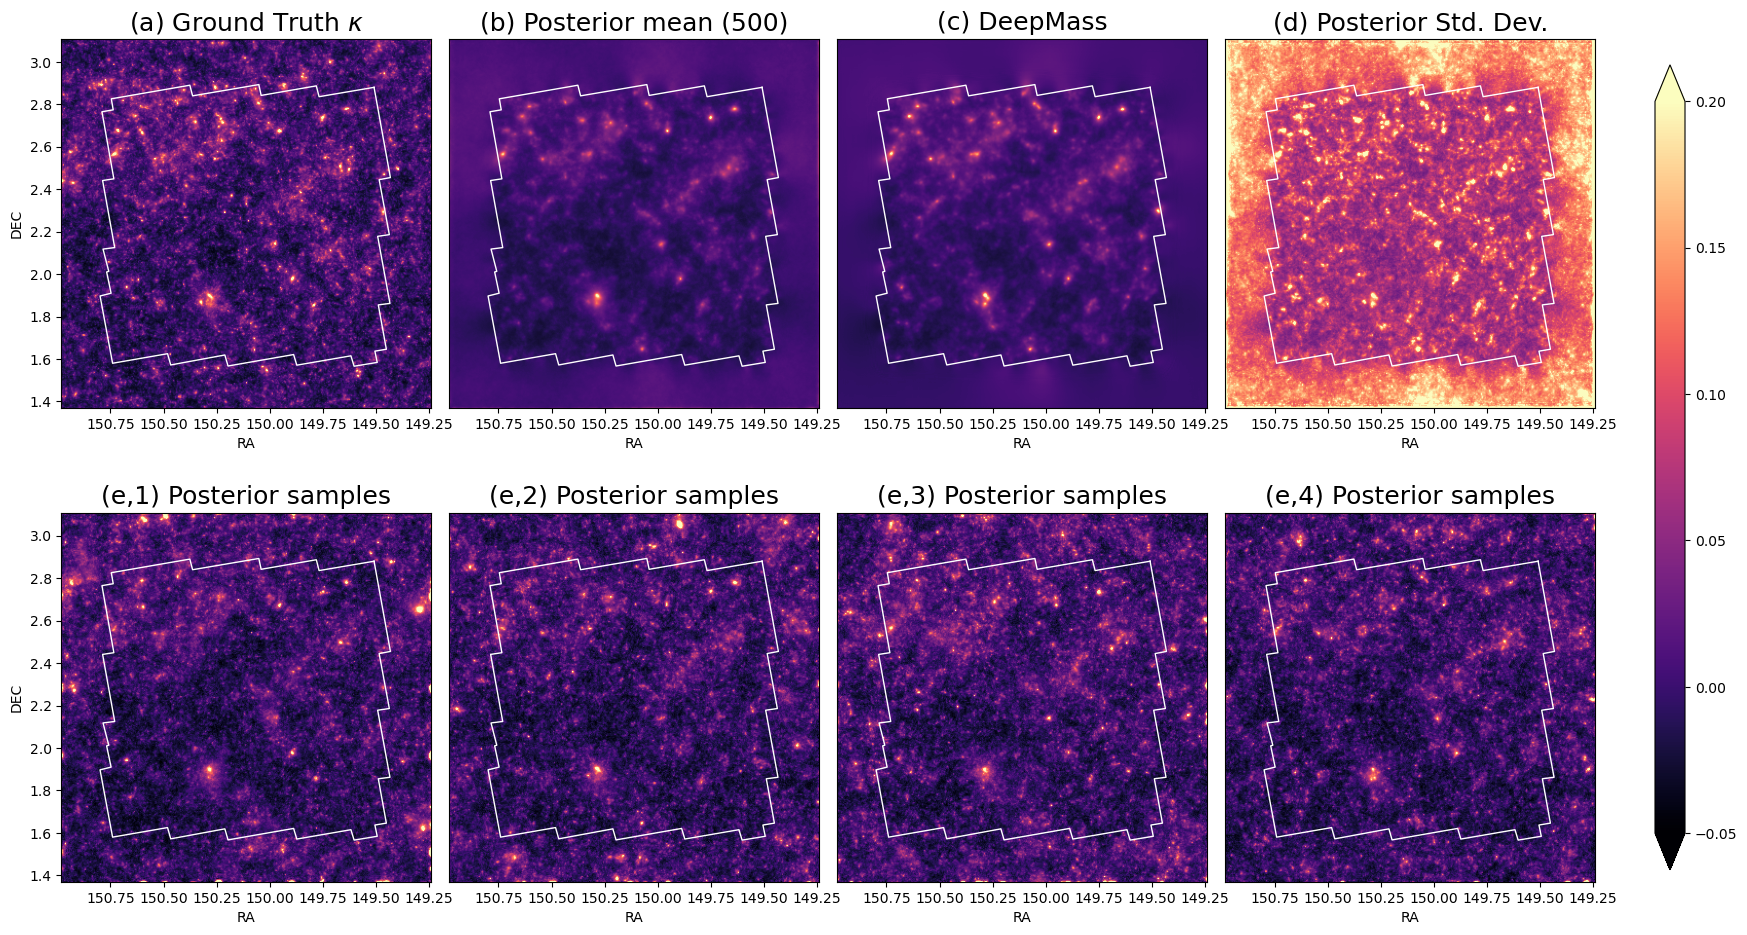

In [10]:
width = 360
resolution = 0.29

vmin = -0.05
vmax = 0.2

f, axes = plt.subplots(2, 4, sharey=False, figsize=(20,11.5), dpi=100)

# Ground truth
im = axes[0,0].imshow(convergence, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[0,0].invert_xaxis()
#axes[0,0].set_xlim(axes[0].gca().get_xlim()[::-1])
#axes[0,0].invert_yaxis()
ra, dec = np.array(COSMOS_VERTICES).T
axes[0,0].plot(ra, dec,  c='w', lw=1)
axes[0,0].set_aspect('equal')
axes[0,0].set_xlabel('RA')
axes[0,0].set_ylabel('DEC')
axes[0,0].set_title(r'(a) Ground Truth $\kappa$', fontsize=18)
divider = make_axes_locatable(axes[0,0])
#cax = divider.append_axes("right", size="5%", pad=0.)
#f.colorbar(im, cax=cax)

# Gaussian denosier
post_mean = denoised[...].mean(axis=0).reshape(360,360)

#np.save('results/posterior_mean_nsm_validation.npy', post_mean)
im = axes[0,1].imshow(post_mean, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[0,1].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[0,1].plot(ra, dec,  c='w', lw=1)
axes[0,1].set_aspect('equal')
axes[0,1].set_xlabel('RA')
axes[0,1].get_yaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[0,1].set_title('(b) Posterior mean ({})'.format(samples.shape[0]), fontsize=18)
divider = make_axes_locatable(axes[0,1])
#cax = divider.append_axes("right", size="5%", pad=0.)
#f.colorbar(im, cax=cax)

#np.save('results/deepmass_validation.npy', deepmass)
# Gaussian + Denoising Auto Encoder denoiser
#deepmass = np.load('../../notebooks/results/kappa_deepmassv2.npy')
deepmass = fits.getdata('./deepmass-estimate.fits').astype('float32')
im = axes[0,2].imshow(deepmass, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[0,2].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[0,2].plot(ra, dec,  c='w', lw=1)
axes[0,2].set_aspect('equal')
axes[0,2].set_xlabel('RA')
axes[0,2].get_yaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[0,2].set_title('(c) DeepMass', fontsize=18)
divider = make_axes_locatable(axes[0,2])
#cax = divider.append_axes("right", size="5%", pad=0.)
#f.colorbar(im, cax=cax)

# DAE output
im = axes[0,3].imshow(denoised[...].std(0), origin='lower', cmap='magma',
                      extent=get_extend_radec(resolution, width),
                      aspect="auto", vmin=0., vmax=0.035)
axes[0,3].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[0,3].plot(ra, dec,  c='w', lw=1)
axes[0,3].set_aspect('equal')
axes[0,3].set_xlabel('RA')
axes[0,3].get_yaxis().set_ticks([])
#axes[3].set_ylabel('dec')
axes[0,3].set_title('(d) Posterior Std. Dev.', fontsize=18)
divider = make_axes_locatable(axes[0,3])
#cax = divider.append_axes("right", size="5%", pad=0.0)
#f.colorbar(im, cax=cax)

for i in range(4):
    # Gaussian denosier
    im = axes[1,i].imshow(denoised[i+15,...].reshape(360,360), origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
    axes[1,i].invert_xaxis()
    #axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
    ra, dec = np.array(COSMOS_VERTICES).T
    axes[1,i].plot(ra, dec,  c='w', lw=1)
    axes[1,i].set_aspect('equal')
    axes[1,i].set_xlabel('RA')
    if i==0:
        axes[1,i].set_ylabel('DEC')
    else:
        axes[1,i].get_yaxis().set_ticks([])
    axes[1,i].set_title('(e,{}) Posterior samples'.format(i+1), fontsize=18)
    divider = make_axes_locatable(axes[1,i])
    #cax = divider.append_axes("right", size="5%", pad=0.)
    #f.colorbar(im, cax=cax)
#f.colorbar(im, ax=axes.ravel().tolist())

cbar_ax = f.add_axes([.83, 0.15, 0.015, 0.7])
f.colorbar(im, cax=cbar_ax, extend='both')

#plt.colorbar(gt)
#"""
f.tight_layout()

f.subplots_adjust(wspace=0.05, hspace=-0.25, right=0.8)
#"""
#ax=axes.ravel().tolist())
#savefig('gauss-res-0.284.pdf')
savefig('plots/validation-comparison.pdf', bbox_inches='tight')

In [11]:
mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

In [12]:
def rmse(a, b, mask):
    a = a - (mask*a).mean()
    b = b - (mask*b).mean()
    return(np.sqrt(np.sum(mask*(a-b)*(a-b))/np.sum(mask)))

def rmse(a, b, mask):
    a = a - (mask*a).mean()
    b = b - (mask*b).mean()
    return(np.sqrt(np.sum(mask*(a-b)*(a-b))/np.sum(mask)))

mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

def r(a, b, mask):
    return np.cov(mask*a, mask*b)[0,1]/np.std(mask*a)/np.std(mask*b)

pm = samples[:,...].mean(0)
print('Posterior mean r:   ', r(convergence.flatten(), pm.flatten(), mask.flatten()))
print('Posterior mean RMSE:', rmse(denoised.mean(0), convergence, mask))

Posterior mean r:    0.6827350006315542
Posterior mean RMSE: 0.021581768560578966


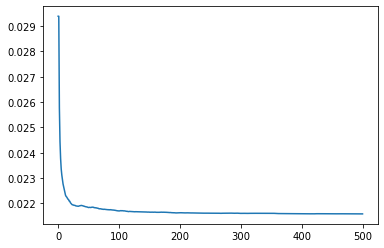

In [13]:
l = [rmse(convergence, samples[0,...].reshape(360,360), mask)]
for i in range(1,samples.shape[0]):
    l.append(rmse(convergence, samples[:i,...].mean(0).reshape(360,360), mask))
    
plot(l)

## Power spectrum

In [14]:
gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = np.load(gaussian_path).astype('float32')

l_true, C_true = measure_power_spectrum(convergence, pixel_size)

In [15]:
import jax
from jax_lensing.spectral import measure_power_spectrum
resolution = 0.29
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

wiener = np.load('../../notebooks/results/gaussian_samples.npy')

mps = jax.vmap(measure_power_spectrum, in_axes=[0,None])
ell_post, cl_post = mps(denoised[...], pixel_size)
cl_post_mean = cl_post.mean(0)
cl_post_std = cl_post.std(0)

input_map = 1.*np.random.randn(1,360,360)
ell_post, cl_input = mps(input_map, pixel_size)

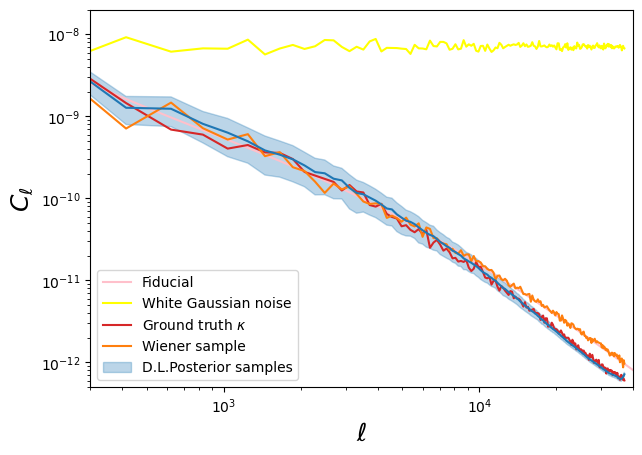

In [16]:
figure(figsize=(7,5), dpi=100)

kwargs = dict(linewidth=1.5)

plot(ps_data_th[0,:], ps_data_th[1,:], color='pink', label='Fiducial', **kwargs)

loglog(l_true, cl_input[0,...], color='yellow', label='White Gaussian noise', **kwargs)

l_true, C_true = measure_power_spectrum(convergence, pixel_size)
loglog(l_true, C_true, color='tab:red', label=r'Ground truth $\kappa$', **kwargs)

l_true, C_true = measure_power_spectrum(wiener[0,...], pixel_size)
loglog(l_true, C_true, color='tab:orange', label='Wiener sample', **kwargs)

plot(ell_post[0,...], cl_post_mean, color='tab:blue', **kwargs)
fill_between(ell_post[0,...], cl_post_mean-cl_post_std,
             cl_post_mean+cl_post_std, color='tab:blue' ,alpha=0.3, label=r'D.L.Posterior samples')

legend()
ylim(5.e-13,2e-8)
xlim(300,4e4)
xscale('log')
yscale('log')
ylabel(r'$C_\ell$', fontsize=18)
xlabel(r'$\ell$', fontsize=18)

savefig('plots/ps-ODE-comparison-1.pdf', bbox_inches='tight')

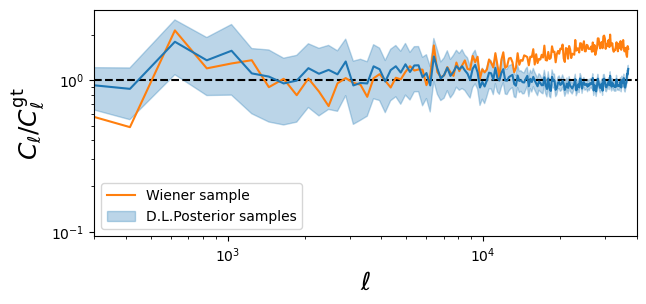

In [17]:
figure(figsize=(7,3), dpi=100)

kwargs = dict(linewidth=1.5)

hlines(y=1., xmin=300,xmax=4e4, linestyle='--', color='k')

l_true, C_true = measure_power_spectrum(convergence, pixel_size)

l_true, C_wiener = measure_power_spectrum(wiener[0,...], pixel_size)
plot(l_true, C_wiener/C_true, color='tab:orange', label='Wiener sample', **kwargs)


ell_post, cl_post = mps(denoised, pixel_size)
mean = (cl_post/C_true).mean(0)
std = (cl_post/C_true).std(0)
plot(l_true, mean, color='tab:blue', **kwargs)
fill_between(l_true, mean-std,
             mean+std, color='tab:blue' ,alpha=0.3, label='D.L.Posterior samples')

legend()
#ylim(5.e-13,6e-9)
xlim(300,4e4)
xscale('log')
yscale('log')
ylabel(r'$C_\ell/C_\ell^\mathrm{gt}$', fontsize=18)
xlabel(r'$\ell$', fontsize=18)
savefig('plots/ps-ODE-comparison-2.pdf', bbox_inches='tight')

## COSMOS

In [18]:
mps = jax.vmap(measure_power_spectrum, in_axes=[0,None])
ell_cosmos, cl_cosmos = mps(cosmos, pixel_size)
cl_cosmos_mean = cl_cosmos.mean(0)
cl_cosmos_std = cl_cosmos.std(0)

In [19]:
from jax_lensing.utils import load_dataset
dataset = "kappatng"
batch_size = 100
map_size=360
noise_dist_std=.1
train_split='90%'
train_set = load_dataset(dataset,
                         batch_size,
                         map_size,
                         noise_dist_std,
                         train_split)
batch = next(train_set)

In [20]:
mps = jax.vmap(measure_power_spectrum, in_axes=[0,None])
ell_data, cl_data = mps(batch['x'][...,0], pixel_size)
cl_data_mean = cl_data.mean(0)
cl_data_std = cl_data.std(0)

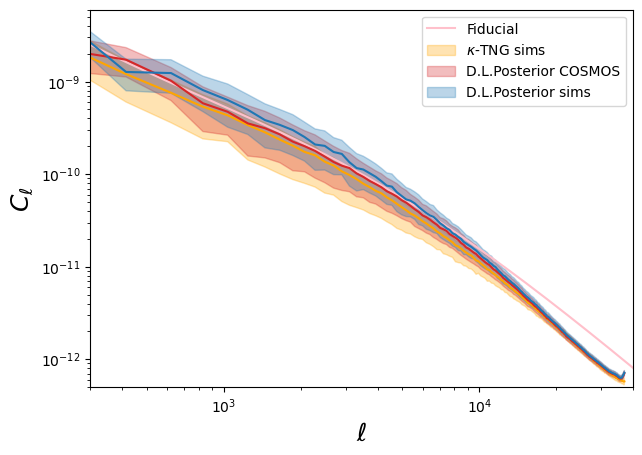

In [21]:
figure(figsize=(7,5), dpi=100)

kwargs = dict(linewidth=1.5)

plot(ps_data_th[0,:], ps_data_th[1,:], color='pink', label='Fiducial', **kwargs)

plot(ell_data[0,...], cl_data_mean, color='orange', **kwargs)
fill_between(ell_data[0,...], cl_data_mean-cl_cosmos_std,
             cl_data_mean+cl_data_std, color='orange', fc='orange',alpha=.3, label=r'$\kappa$-TNG sims')

plot(ell_cosmos[0,...], cl_cosmos_mean, color='tab:red', **kwargs)
fill_between(ell_cosmos[0,...], cl_cosmos_mean-cl_cosmos_std,
             cl_cosmos_mean+cl_cosmos_std, color='tab:red', fc='tab:red',alpha=.3, label='D.L.Posterior COSMOS')

plot(ell_post[0,...], cl_post_mean, color='tab:blue', **kwargs)
fill_between(ell_post[0,...], cl_post_mean-cl_post_std,
             cl_post_mean+cl_post_std, color='tab:blue', fc='tab:blue',alpha=.3, label='D.L.Posterior sims')


legend()
ylim(5.e-13,6e-9)
xlim(300,4e4)
xscale('log')
yscale('log')
ylabel(r'$C_\ell$', fontsize=18)
xlabel(r'$\ell$', fontsize=18)

savefig('plots/ps-ODE-comparison-cosmos.pdf', bbox_inches='tight')

In [22]:
ks_cosmos = fits.getdata('../../data/COSMOS/ks_e_0.29arcmin360.fits')

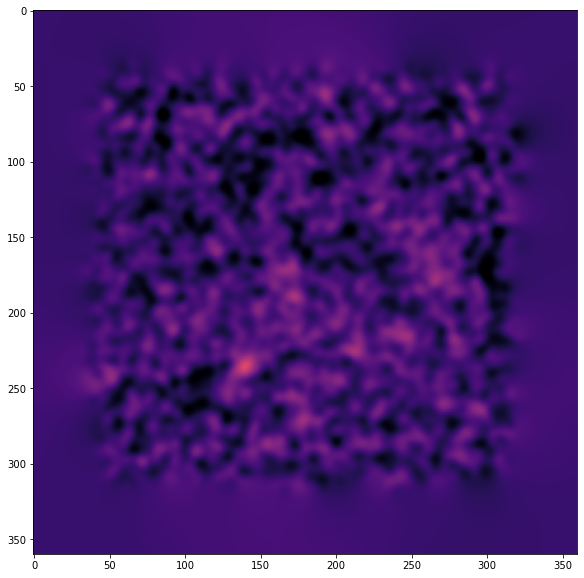

In [23]:
import jax.numpy as jnp
from scipy.ndimage import gaussian_filter
from jax_lensing.inversion import ks93inv, ks93

g1 = fits.getdata('../../data/COSMOS/cosmos_full_e1_0.29arcmin360.fits').astype('float32')
g2 = fits.getdata('../../data/COSMOS/cosmos_full_e2_0.29arcmin360.fits').astype('float32')
#g1, g2 = ks93inv(convergence, zeros_like(convergence))
#g1 += 0.148*np.random.randn(360,360)
#g2 += 0.148*np.random.randn(360,360)
std1 = fits.getdata('../../data/COSMOS/std1.fits')
std2 = fits.getdata('../../data/COSMOS/std2.fits')
std1 = jnp.expand_dims(std1.astype('float32'), -1)
std2 = jnp.expand_dims(std2.astype('float32'), -1)

g1 += std1[...,0] * jax.random.normal(jax.random.PRNGKey(42), g1.shape)
g2 += std2[...,0] * jax.random.normal(jax.random.PRNGKey(43), g1.shape)
g1 *= mask
g2 *= mask
#figure()
#imshow(g1)
ks,_ = ks93(g1,g2)
scale = 1/.29
cosmos_ks = gaussian_filter(ks, sigma=scale) # sigma = 2 arcmin
figure(figsize=[10,10])
imshow(cosmos_ks, cmap='magma', vmin=vmin, vmax=vmax)
#colorbar()

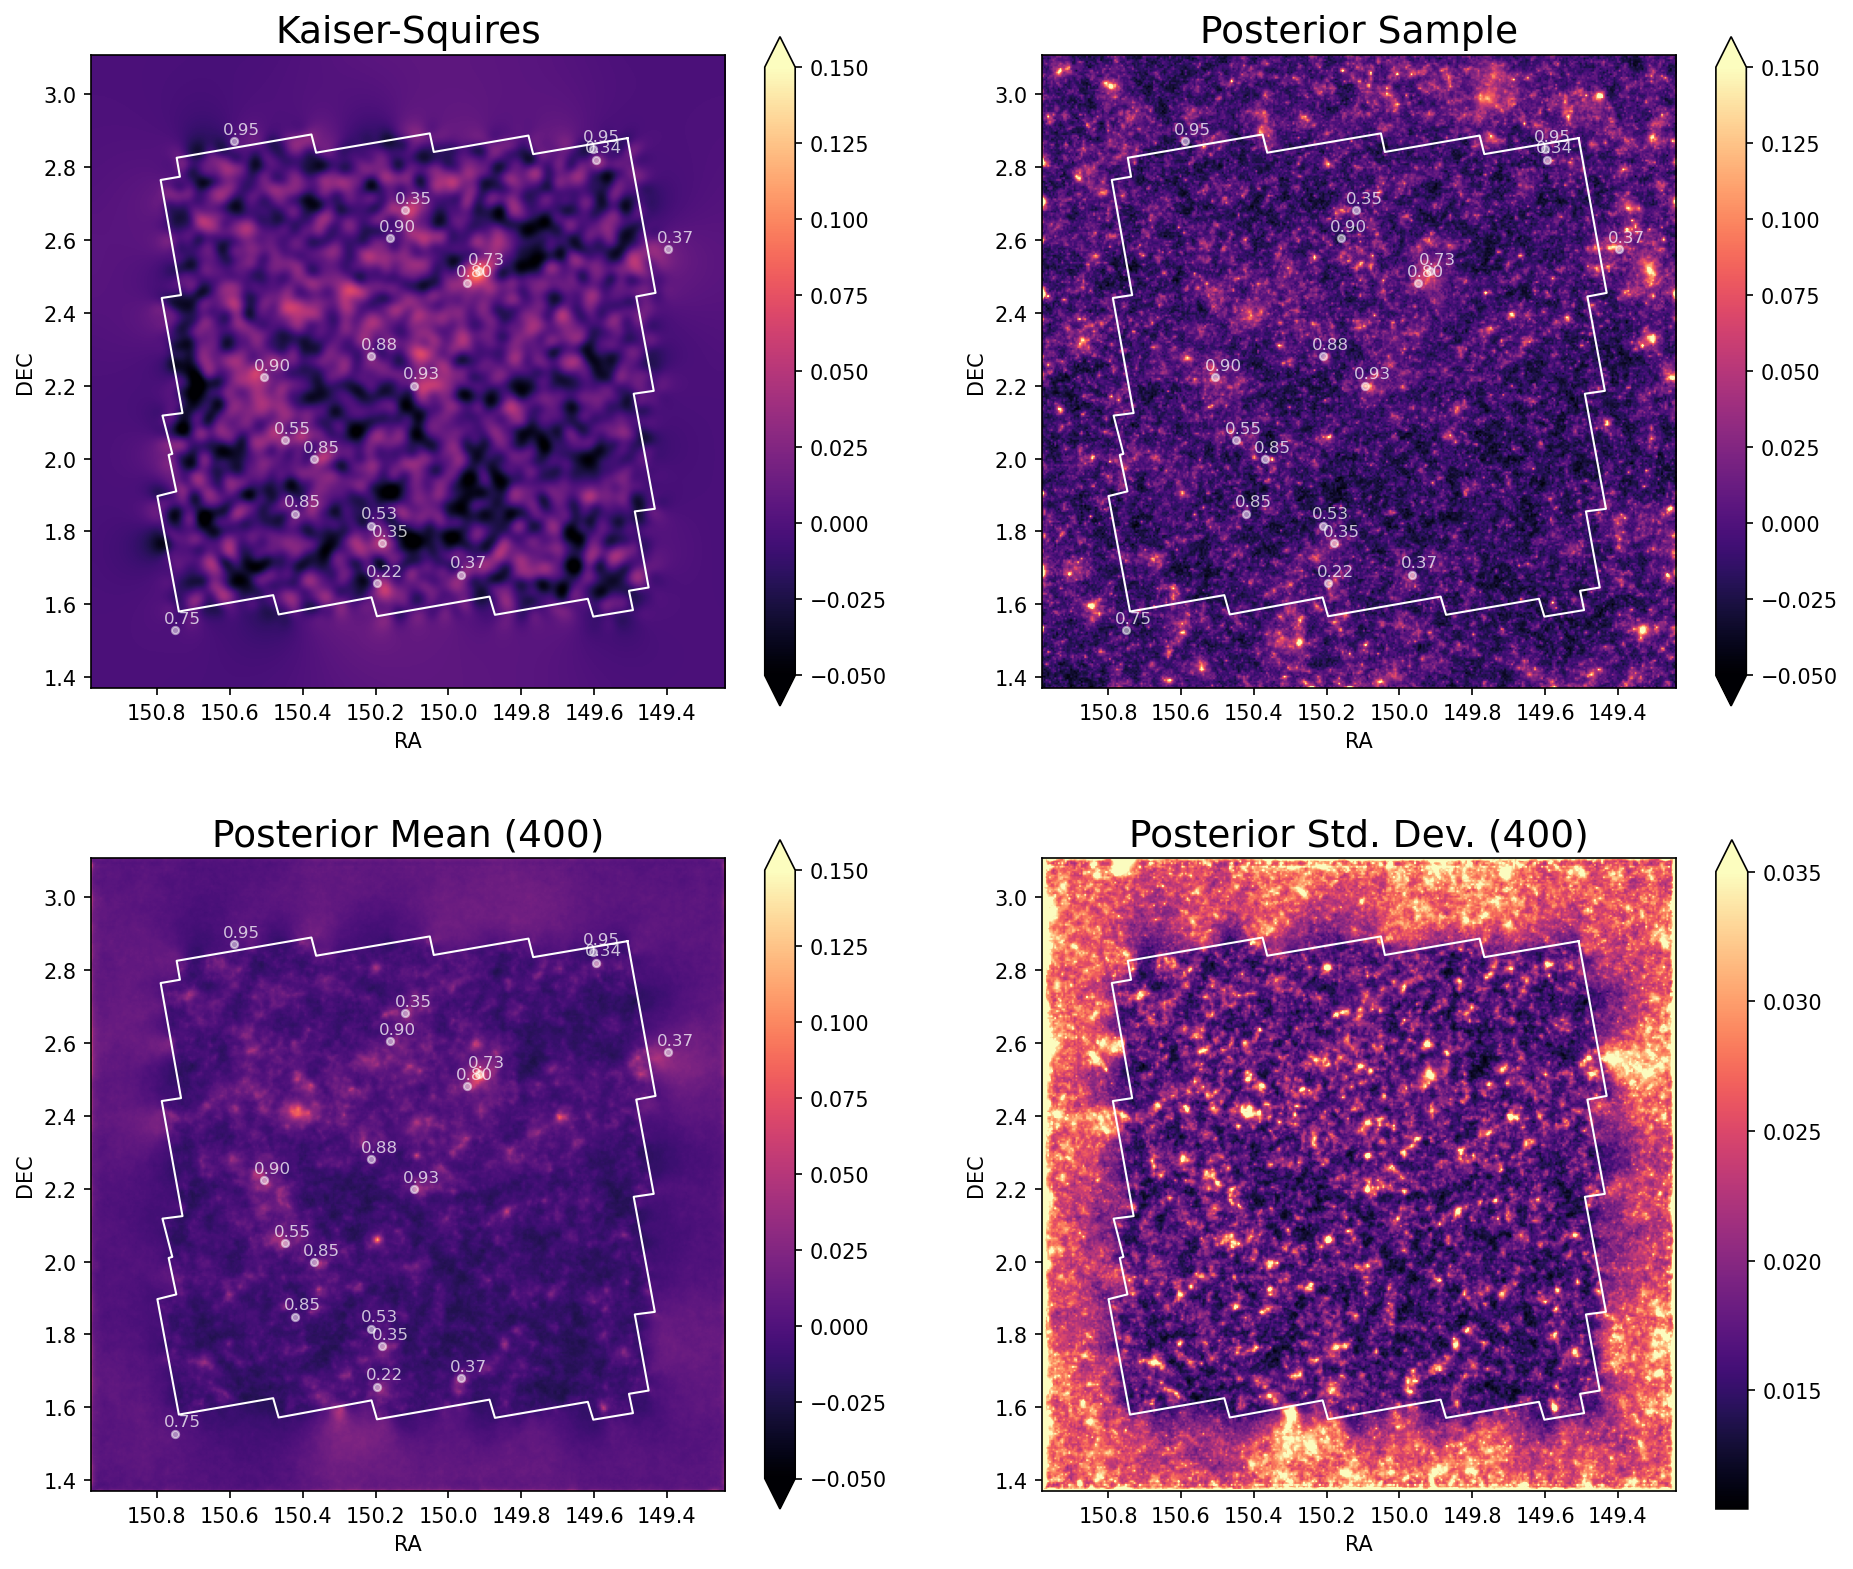

In [24]:
resolution = 0.29
width = 360

kwargs = dict(cmap='magma', origin='lower', extent=get_extend_radec(resolution, width), vmin=-.05, vmax=0.15)

figure(figsize=[15,13], dpi=150)

subplot(221)
imshow(cosmos_ks[...],**kwargs)
colorbar(extend='both')
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('RA')
ylabel('DEC')
title(r'Kaiser-Squires', fontsize=18)

xclusters = np.loadtxt("../../data/xray.txt")
m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=12, alpha=.5)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, color='w', alpha=.75)


subplot(223)
imshow(cosmos[:,...].mean(axis=0).reshape(360,360),**kwargs)
colorbar(extend='both')
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('RA')
ylabel('DEC')
title('Posterior Mean ({})'.format(cosmos.shape[0]), fontsize=18)

xclusters = np.loadtxt("../../data/xray.txt")
m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=12, alpha=.5)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, color='w', alpha=.75)
        

subplot(222)
imshow(cosmos[5,...].reshape(360,360), **kwargs)
colorbar(extend='both')
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('RA')
ylabel('DEC')
title('Posterior Sample', fontsize=18)

xclusters = np.loadtxt("../../data/xray.txt")
m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=12, alpha=.5)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, color='w', alpha=.75)
        
subplot(224)
imshow(cosmos[:,...].std(axis=0).reshape(360,360), cmap='magma', origin='lower', 
       extent=get_extend_radec(resolution, width),
       vmax=.035)
colorbar(extend='max')
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('RA')
ylabel('DEC')
title('Posterior Std. Dev. ({})'.format(cosmos.shape[0]), fontsize=18)

        
savefig('plots/COSMOS-figure-ODE.pdf', bbox_inches='tight')

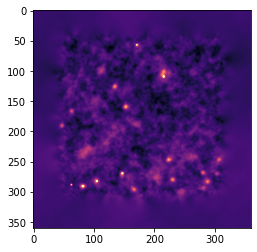

In [25]:
#mcalens = fits.getdata('res/xx_mcalens5.fits')
mcalens = fits.getdata('simcosmo_mcalens5.fits').astype('float32')
imshow(mcalens, cmap='magma', vmin=-0.05, vmax=0.2)

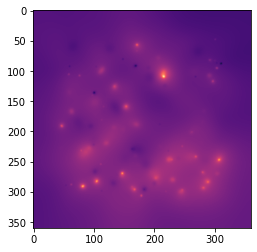

In [26]:
#sparse = fits.getdata('res/xx_sparse3.fits')
sparse = fits.getdata('simcosmo_glimpse4.fits').astype('float32')
imshow(sparse, cmap='magma', vmin=-0.05, vmax=0.2)

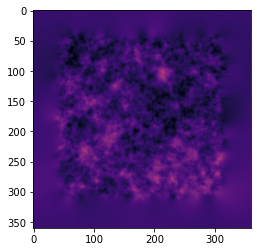

In [27]:
wiener_solution = np.load('res/wiener_solution.npy')
imshow(wiener_solution, cmap='magma', vmin=-0.05, vmax=0.2)

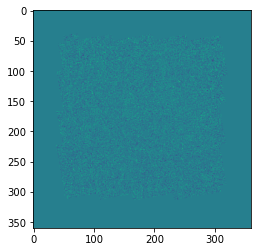

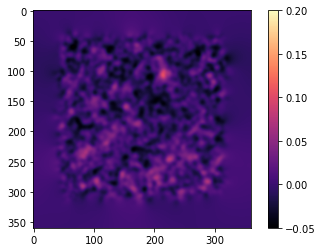

In [28]:
import jax.numpy as jnp
from scipy.ndimage import gaussian_filter
from jax_lensing.inversion import ks93inv, ks93
g1, g2 = ks93inv(convergence, zeros_like(convergence))

std1 = fits.getdata('../../data/COSMOS/std1.fits')
std2 = fits.getdata('../../data/COSMOS/std2.fits')
std1 = jnp.expand_dims(std1.astype('float32'), -1)
std2 = jnp.expand_dims(std2.astype('float32'), -1)

g1 += std1[...,0] * jax.random.normal(jax.random.PRNGKey(42), g1.shape)
g2 += std2[...,0] * jax.random.normal(jax.random.PRNGKey(43), g1.shape)
g1 *= mask
g2 *= mask
figure()
imshow(g1)
ks,_ = ks93(g1,g2)
scale = 1/.29
smooth_ks = gaussian_filter(ks, sigma=scale) # sigma = 2 arcmin
figure()
imshow(smooth_ks, cmap='magma', vmin=vmin, vmax=vmax)
colorbar()

In [29]:
def rmse2(a, b, mask):
    a = a - (mask*a).mean()
    b = b - (mask*b).mean()
    return(np.sqrt(np.sum(mask*(a-b)*(a-b))/np.sum(mask)))
print('Posterior Mean:', "{:.2e}".format(rmse2(convergence, denoised[:,...].mean(0).reshape(360,360), mask)))

Posterior Mean: 2.16e-02


In [30]:
print("KS", '{:.2e}'.format(rmse2(smooth_ks, convergence, mask)))
print("Sparse", '{:.2e}'.format(rmse2(sparse, convergence, mask)))
print("MCALens", '{:.2e}'.format(rmse2(mcalens, convergence, mask)))
print("Wiener", '{:.2e}'.format(rmse2(wiener_solution, convergence, mask)))
print("Posterior mean", '{:.2e}'.format(rmse2(denoised.mean(0), convergence, mask)))
print("DeepMass", '{:.2e}'.format(rmse2(deepmass, convergence, mask)))

print()

def r(a, b, mask):
    a = a.flatten()
    b = b.flatten()
    mask = mask.flatten()
    return np.cov(mask*a, mask*b)[0,1]/np.std(mask*a)/np.std(mask*b)

print("KS", r(smooth_ks, convergence, mask))
print("Posterior mean hmc", r(samples.mean(0), convergence, mask))
print("Posterior mean hmc+ode", r(denoised.mean(0), convergence, mask))
print("DeepMass", r(deepmass, convergence, mask))
print("Sparse", r(sparse, convergence, mask))
print("MCALens", r(mcalens, convergence, mask))
print("Wiener", r(wiener_solution, convergence, mask))

KS 2.40e-02
Sparse 2.84e-02
MCALens 2.19e-02
Wiener 2.31e-02
Posterior mean 2.16e-02
DeepMass 2.18e-02

KS 0.5723419558955859
Posterior mean hmc 0.6827350006315542
Posterior mean hmc+ode 0.6827763545776642
DeepMass 0.6769155918913958
Sparse 0.41740543232369215
MCALens 0.6676293248022401
Wiener 0.6119341412724268


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/tensorflow-gpu-2.5.0/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


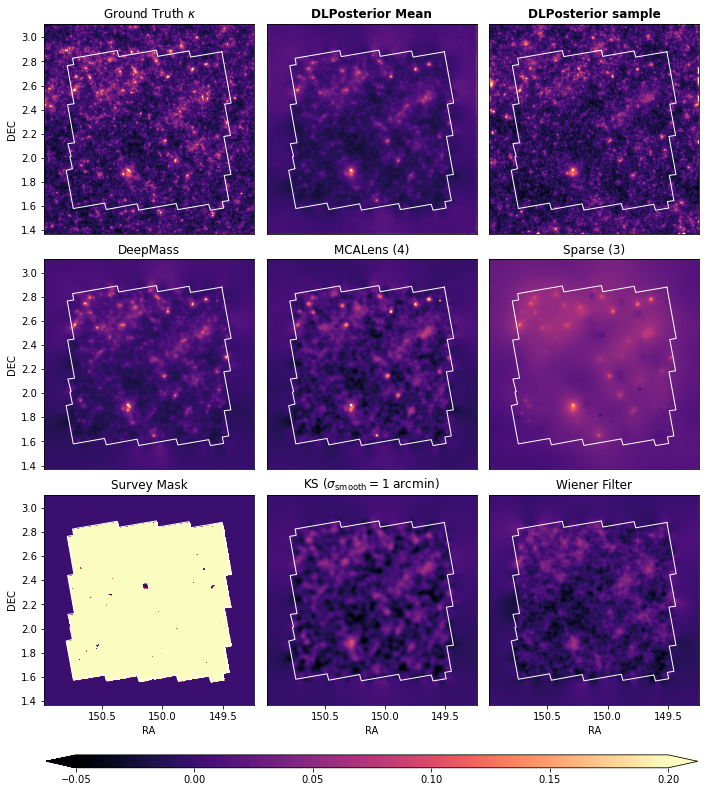

In [31]:
f, axes = plt.subplots(3, 3, sharey=False, figsize=(10,12))

# Ground truth
im = axes[0,0].imshow(convergence, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[0,0].invert_xaxis()
#axes[0,0].set_xlim(axes[0].gca().get_xlim()[::-1])
#axes[0,0].invert_yaxis()
ra, dec = np.array(COSMOS_VERTICES).T
axes[0,0].plot(ra, dec,  c='w', lw=1)
axes[0,0].set_aspect('equal')
axes[0,0].get_xaxis().set_ticks([])
axes[0,0].set_ylabel('DEC')
axes[0,0].set_title(r'Ground Truth $\kappa$')#, fontsize=18)
divider = make_axes_locatable(axes[0,0])

im = axes[0,1].imshow(denoised.mean(0), origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[0,1].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[0,1].plot(ra, dec,  c='w', lw=1)
axes[0,1].set_aspect('equal')
#axes[0,1].set_xlabel('RA')
axes[0,1].get_yaxis().set_ticks([])
axes[0,1].get_xaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[0,1].set_title('DLPosterior Mean', weight='bold')
divider = make_axes_locatable(axes[0,1])

im = axes[0,2].imshow(denoised[10,...].reshape(360,360), origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[0,2].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[0,2].plot(ra, dec,  c='w', lw=1)
axes[0,2].set_aspect('equal')
axes[0,2].get_yaxis().set_ticks([])
axes[0,2].get_xaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[0,2].set_title('DLPosterior sample', weight='bold')
divider = make_axes_locatable(axes[0,2])

im = axes[1,0].imshow(deepmass, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[1,0].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[1,0].plot(ra, dec,  c='w', lw=1)
axes[1,0].set_aspect('equal')
axes[1,0].set_ylabel('DEC')
axes[1,0].get_xaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[1,0].set_title('DeepMass')
divider = make_axes_locatable(axes[1,0])

im = axes[1,1].imshow(mcalens, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[1,1].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[1,1].plot(ra, dec,  c='w', lw=1)
axes[1,1].set_aspect('equal')
#axes[1,1].set_ylabel('DEC')
axes[1,1].get_xaxis().set_ticks([])
axes[1,1].get_yaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[1,1].set_title('MCALens (4)')
divider = make_axes_locatable(axes[1,1])

im = axes[1,2].imshow(sparse, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[1,2].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[1,2].plot(ra, dec,  c='w', lw=1)
axes[1,2].set_aspect('equal')
#axes[1,1].set_ylabel('DEC')
axes[1,2].get_xaxis().set_ticks([])
axes[1,2].get_yaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[1,2].set_title('Sparse (3)')
divider = make_axes_locatable(axes[1,2])

im = axes[2,0].imshow(mask, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[2,0].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[2,0].plot(ra, dec,  c='w', lw=1)
axes[2,0].set_aspect('equal')
axes[2,0].set_ylabel('DEC')
axes[2,0].set_xlabel('RA')
#axes[1].set_ylabel('dec')
axes[2,0].set_title('Survey Mask')
divider = make_axes_locatable(axes[2,0])

im = axes[2,1].imshow(smooth_ks, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[2,1].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[2,1].plot(ra, dec,  c='w', lw=1)
axes[2,1].set_aspect('equal')
#axes[2,1].set_ylabel('DEC')
axes[2,1].set_xlabel('RA')
axes[2,1].get_yaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[2,1].set_title(r'KS ($\sigma_\mathrm{smooth}=1$ arcmin)')
divider = make_axes_locatable(axes[2,1])

im = axes[2,2].imshow(wiener_solution, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[2,2].invert_xaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
axes[2,2].plot(ra, dec,  c='w', lw=1)
axes[2,2].set_aspect('equal')
#axes[2,2].set_ylabel('DEC')
axes[2,2].set_xlabel('RA')
axes[2,2].get_yaxis().set_ticks([])
#axes[1].set_ylabel('dec')
axes[2,2].set_title(r'Wiener Filter')
divider = make_axes_locatable(axes[2,2])

cbar_ax = f.add_axes([.078, 0.05, .905, 0.015])
f.colorbar(im, cax=cbar_ax, extend='both', orientation="horizontal")

#plt.colorbar(gt)
#"""
f.tight_layout()

f.subplots_adjust(wspace=0.06, hspace=-0.3, bottom=0.05)

savefig('plots/map-comparison.pdf')